In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, \
                            recall_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/t_kakhanovich/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/t_kakhanovich/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/t_kakhanovich/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
from nltk.corpus import stopwords

In [6]:
df = pd.read_csv('train_data.csv', lineterminator='\n')

In [7]:
def del_spoiler_text(text):
    return text.replace('<spoiler>', '').replace('<\\spoiler>', '').replace('  ', ' ')

In [8]:
def del_spoiler_lemma(text):
    return text.replace('spoiler', '').replace('\\  ', '').replace('  ', ' ')

In [9]:
df.loc[df['hasSpoiler'] == 1, 'text'] = \
    df.loc[df['hasSpoiler'] == 1, 'text'].apply(del_spoiler_text)

df.loc[df['hasSpoiler'] == 1, 'lemmatized_text'] = \
    df.loc[df['hasSpoiler'] == 1, 'lemmatized_text'].apply(del_spoiler_lemma)

In [10]:
df.isnull().any()

name               False
author             False
annotation          True
text               False
mark               False
hasSpoiler         False
lemmatized_text    False
names_amount       False
dtype: bool

In [11]:
df['annotation'].fillna('', inplace=True)

In [12]:
true_class_weight = df['hasSpoiler'].mean()

In [13]:
def custom_f1_score(y_true, y_pred):
    thresholds = np.arange(0.5, 0.95, 0.05)

    f1_result = np.array([f1_score(y_true, y_pred >= thres) for thres in thresholds])

    return np.max(f1_result)

In [14]:
thres_f1_score = make_scorer(custom_f1_score, greater_is_better=True)

In [15]:
def print_result(target, preds):
    thresholds = np.arange(0.05, 0.95, 0.05)
    f1_result = np.array([f1_score(target, preds >= thres) for thres in thresholds]) 
    
    plt.figure(figsize=(10, 8))
    plt.title('Threshold/F1-score results')
    plt.xlabel('Threshold')
    plt.ylabel('F1-score')
    plt.plot(thresholds, f1_result)
    plt.show()
    
    best_threshold = thresholds[np.argmax(f1_result)]
    print(f'Best threshold for F1-score: {best_threshold}\n' 
            f'F1-score: {np.max(f1_result)}')
    print('\n')
    print(classification_report(target, preds >= best_threshold))

In [16]:
X = df[['lemmatized_text', 'mark', 'names_amount']]
y = df['hasSpoiler']

In [17]:
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X.loc[:, ['mark', 'names_amount']])

In [18]:
X.loc[:, 'mark'] = X_transformed[:, 0].copy()
X.loc[:, 'names_amount'] = X_transformed[:, 1].copy()

/home/t_kakhanovich/miniconda3/envs/spoilers/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [19]:
X

,lemmatized_text,mark,names_amount
0,а жаль мочь получиться вполне интересный и нег...,3.732077,0.538164
1,должный сказать что прочтение черновик я неско...,3.271765,0.538164
2,а внутро у она неонка с когда-то год этак деся...,2.197702,-0.312832
3,этот книга никак не дотягивать до хороший фант...,2.044265,-0.525581
4,вещь не вторичный а даже третичный если творче...,1.890827,-0.525581
...,...,...,...
84397,переосмысление сказка это всегда интересный го...,-0.257298,-0.525581
84398,занятный альтернативный взгляд на классический...,-0.717611,-0.100083
84399,самый характерный пример убитый наш книгоиздат...,-0.103861,-0.525581
84400,мой самый любимый произведение читать не отрыв...,-0.410736,-0.312832


# Tf-Idf + SGDClassifier model

In [24]:
vect = TfidfVectorizer(stop_words=stopwords.words('russian'))
clf = SGDClassifier(penalty='elasticnet', loss='modified_huber', shuffle=True, n_jobs=-1, random_state=42, 
                    class_weight={0: true_class_weight, 1: 1-true_class_weight})

In [25]:
column_transformer = ColumnTransformer([
    ('tf-idf', vect, 'lemmatized_text')
], remainder='passthrough')

In [26]:
pipe = Pipeline([('preprocess', column_transformer), ('clf', clf)])

In [27]:
param_grid = {
    'clf__alpha': [1e-5, 1e-6, 1e-7],
    'clf__l1_ratio': [0.1, 0.3, 0.5],
    'clf__average': [10, 20, 50]
}

In [28]:
estimator = RandomizedSearchCV(pipe, param_grid, scoring=thres_f1_score, n_jobs=-1, n_iter=20,
                               cv=StratifiedKFold(5), random_state=42, verbose=1)

In [29]:
estimator.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('tf-idf',
                                                                               TfidfVectorizer(stop_words=['и',
                                                                                                           'в',
                                                                                                           'во',
                                                                                                           'не',
                                                                                                           'что',
                                                                                                           'он',


In [30]:
estimator.best_params_

{'clf__l1_ratio': 0.3, 'clf__average': 20, 'clf__alpha': 1e-07}

In [31]:
estimator.best_score_

0.21660916706242572

In [32]:
clf = SGDClassifier(loss='modified_huber', penalty='elasticnet', shuffle=True, n_jobs=-1, 
                    random_state=42, l1_ratio=0.3, average=20, alpha=1e-7,
                    class_weight={0: true_class_weight, 1: 1-true_class_weight})

In [33]:
pipe = Pipeline([('preprocess', column_transformer), ('clf', clf)])

In [37]:
y_pred = cross_val_predict(pipe, X, y, cv=StratifiedKFold(5))

In [38]:
f1_score(y, y_pred)

0.21492353484553012

На лемматизированных токенах + признаках: (mark, names_amount) -- качество 0.21.

# Tf-Idf + LogisticRegression model

In [20]:
vect = TfidfVectorizer(stop_words=stopwords.words('russian'))
clf = LogisticRegression(penalty='l2', n_jobs=-1, random_state=42, 
                    class_weight={0: true_class_weight, 1: 1-true_class_weight})

In [21]:
column_transformer = ColumnTransformer([
    ('tf-idf', vect, 'lemmatized_text')
], remainder='passthrough')

In [22]:
l2_param_grid = {
    'clf__C': [1., 5., 10., 50., 100.],
    'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

In [23]:
pipe = Pipeline([('preprocess', column_transformer), ('clf', clf)])

In [24]:
estimator = RandomizedSearchCV(pipe, l2_param_grid, cv=StratifiedKFold(5), 
                               scoring=thres_f1_score, n_jobs=-1, n_iter=20,
                               random_state=42, verbose=1)

In [25]:
estimator.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('tf-idf',
                                                                               TfidfVectorizer(stop_words=['и',
                                                                                                           'в',
                                                                                                           'во',
                                                                                                           'не',
                                                                                                           'что',
                                                                                                           'он',


In [26]:
estimator.best_params_

{'clf__solver': 'newton-cg', 'clf__C': 5.0}

In [27]:
estimator.best_score_

0.23662389536454423

In [28]:
clf = LogisticRegression(penalty='l2', C=5, solver='newton-cg', n_jobs=-1, random_state=42, 
                        class_weight={0: true_class_weight, 1: 1-true_class_weight})

In [29]:
pipe = Pipeline([('preprocess', column_transformer), ('clf', clf)])

In [30]:
y_pred = cross_val_predict(pipe, X, y, cv=StratifiedKFold(5), method='predict_proba')

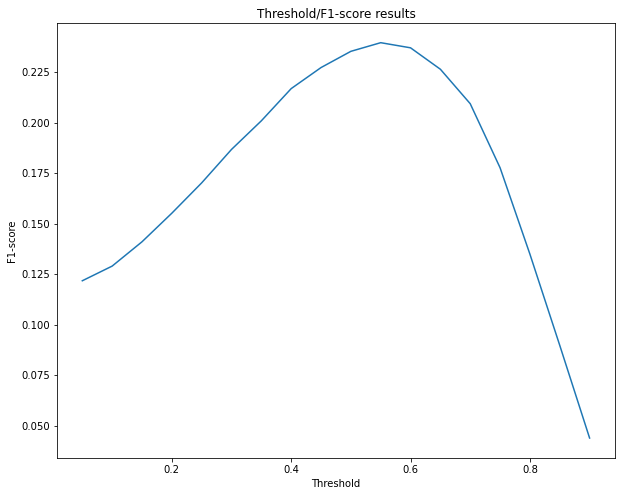

Best threshold for F1-score: 0.55
F1-score: 0.23961787018825517


              precision    recall  f1-score   support

           0       0.95      0.87      0.91     78995
           1       0.17      0.39      0.24      5407

    accuracy                           0.84     84402
   macro avg       0.56      0.63      0.58     84402
weighted avg       0.90      0.84      0.87     84402



In [33]:
print_result(y, y_pred[:, 1])

# w2v + Logistic Regression

In [22]:
from navec import Navec

In [23]:
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [24]:
def get_w2v_vect(token):
    if token in navec:
        return navec[token]
    else:
        return np.zeros(300)

In [25]:
def get_features_from_text(tokenized_text):
    vect = np.array([get_w2v_vect(token) 
                    for token in tokenized_text]).mean(axis=0)
    
    vect_norm = np.linalg.norm(vect)
    
    if vect_norm < 1e-7:
        return vect
    else:
        return vect/vect_norm

### Making w2v embeddings and saving it to the file

In [38]:
w2v_data = np.array([get_features_from_text(tokenized_text)
                    for tokenized_text in X['lemmatized_text']])

In [42]:
with open('w2v_embeddings.npy', 'wb') as fin:
    np.save(fin, w2v_data)

In [26]:
with open('w2v_embeddings.npy', 'rb') as fout:
    w2v_data = np.load(fout)

In [27]:
additional_data = X[['mark', 'names_amount']].to_numpy()

In [28]:
w2v_data = np.hstack((w2v_data, additional_data))

## With l2-penalty

In [70]:
clf = LogisticRegression(penalty='l2', n_jobs=-1, random_state=42, 
                    class_weight={0: true_class_weight, 1: 1-true_class_weight})

l2_param_grid = {
    'C': [1., 5., 10., 50., 100.],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

In [71]:
estimator = RandomizedSearchCV(clf, l2_param_grid, cv=StratifiedKFold(5), 
                               scoring=thres_f1_score, n_jobs=-1, n_iter=20,
                               random_state=42, verbose=1)

In [72]:
estimator.fit(w2v_data, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LogisticRegression(class_weight={0: 0.06406246297481102,
                                                              1: 0.935937537025189},
                                                n_jobs=-1, random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'C': [1.0, 5.0, 10.0, 50.0, 100.0],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=42, scoring=make_scorer(custom_f1_score),
                   verbose=1)

In [73]:
estimator.best_params_

{'solver': 'lbfgs', 'C': 1.0}

In [74]:
estimator.best_score_

0.17345983652441221

In [75]:
clf = LogisticRegression(solver='lbfgs', C=1.0, penalty='l2', n_jobs=-1, random_state=42, 
                    class_weight={0: true_class_weight, 1: 1-true_class_weight})

In [76]:
y_pred = cross_val_predict(clf, w2v_data, y, cv=StratifiedKFold(5), method='predict_proba')

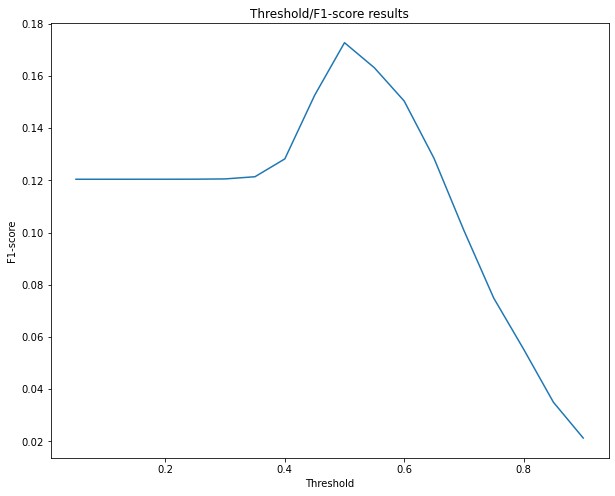

Best threshold for F1-score: 0.5
F1-score: 0.1727127696469446


              precision    recall  f1-score   support

           0       0.95      0.73      0.83     78995
           1       0.11      0.46      0.17      5407

    accuracy                           0.72     84402
   macro avg       0.53      0.60      0.50     84402
weighted avg       0.90      0.72      0.79     84402



In [79]:
print_result(y, y_pred[:, 1])

## With l1/elasticnet-petalty

In [20]:
clf = LogisticRegression(n_jobs=-1, random_state=42, 
                    class_weight={0: true_class_weight, 1: 1-true_class_weight})

In [83]:
el_param_grid = {
    'penalty': ['l1', 'elasticnet'],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7],
    'C': [1., 5., 10., 50., 100.],
    'solver': ['liblinear', 'saga']
}

In [29]:
clf = LogisticRegression(penalty='elasticnet', l1_ratio=0.3, C=5.0, solver='saga',
                         n_jobs=-1, random_state=42, 
                        class_weight={0: true_class_weight, 1: 1-true_class_weight})

In [30]:
y_pred = cross_val_predict(clf, w2v_data, y, cv=StratifiedKFold(5), method='predict_proba')

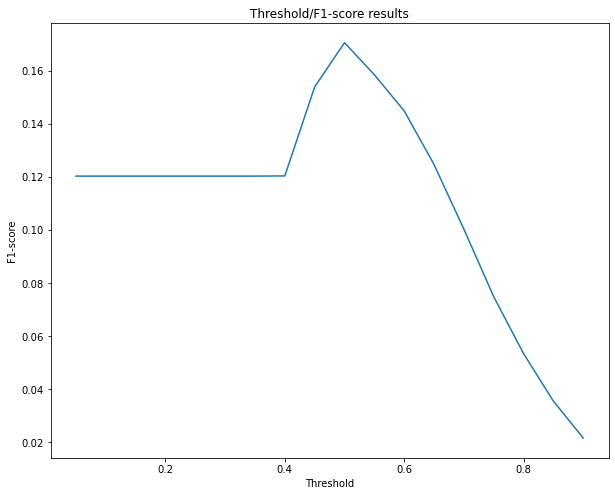

Best threshold for F1-score: 0.5
F1-score: 0.1707422324510932


              precision    recall  f1-score   support

           0       0.95      0.75      0.84     78995
           1       0.11      0.44      0.17      5407

    accuracy                           0.73     84402
   macro avg       0.53      0.59      0.50     84402
weighted avg       0.90      0.73      0.79     84402



In [32]:
print_result(y, y_pred[:, 1])